In [1]:
from agents.state import MessageState
from node_and_edge.context_node import context_node
from node_and_edge.sys_msg_node import sys_msg_node
from node_and_edge.assistant_node import assistant_node
from node_and_edge.sql_note import sql_query_node
from node_and_edge.sql_verify_edge import sql_verify_edge
from node_and_edge.show import show
from langgraph.graph import StateGraph,START,END

In [2]:
state = MessageState()
state['question'] = "Lấy tất cả dữ liệu tử bảng khách hàng"

In [3]:
graph = StateGraph(MessageState)

graph.add_node("context_node",context_node)
graph.add_node("sys_msg_node", sys_msg_node)
graph.add_node("assistant_node", assistant_node)
graph.add_node("sql_query_node",sql_query_node)
graph.add_node("show", show)

graph.add_edge(START, "context_node")
graph.add_edge("context_node", "sys_msg_node")
graph.add_edge("sys_msg_node", "assistant_node")
graph.add_edge("assistant_node", "sql_query_node")
graph.add_conditional_edges("sql_query_node", sql_verify_edge)
graph.add_edge("show", END)

# graph.add_edge("sql_query_node", END)
app = graph.compile()

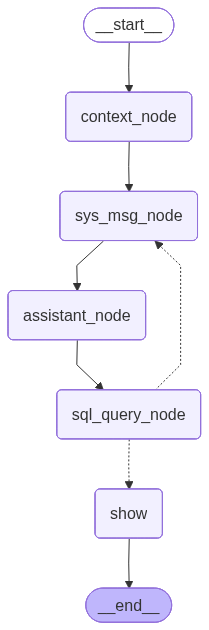

In [4]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [5]:
state = app.invoke(state)

KeyError: 'SQL_error_results'

In [6]:
state

{'question': 'Lấy tất cả dữ liệu tử bảng khách hàng',
 'system_msg': "Bạn là chuyên gia viết SQL postgres để trả lời câu hỏi tiếng Việt/Anh dựa trên mô tả cơ sở dữ liệu cung cấp.\n\nQUY TẮC BẮT BUỘC:\n1) Chỉ tạo câu lệnh SELECT hợp lệ cho postgres; không được tạo DDL/DML.\n2) Luôn ghi rõ schema trước tên bảng (schema.table). Không tự suy ra bảng/cột không có trong mô tả.\n3) Ưu tiên cột/khóa có trong mô tả. Nếu thiếu thông tin, dùng comment ngắn dạng -- TODO:<vấn đề>.\n4) Mặc định giới hạn kết quả để an toàn:\n   - postgres/mysql: dùng LIMIT 200.\n   - mssql: dùng TOP 200 hoặc OFFSET…FETCH (nếu có ORDER BY).\n5) Đặt alias cột ngắn gọn, snake_case; tránh khoảng trắng; không dùng dấu tiếng Việt trong alias.\n6) Đối với lọc thời gian mơ hồ như “gần đây”, hiểu là 6 tháng gần nhất.\n7) Xử lý NULL an toàn với COALESCE khi tính toán/ghép chuỗi.\n8) Khi cần tìm kiếm không phân biệt hoa thường:\n   - postgres: ILIKE.\n   - mysql/mssql: LOWER(col) LIKE LOWER('%kw%') (nếu cần).\n9) Chỉ TRẢ VỀ duy

In [7]:
state["SQL_statement"]

'SELECT \n    customer_id,\n    customer_unique_id,\n    customer_zip_code_prefix,\n    customer_city,\n    customer_state\nFROM \n    olist.olist_customers\nLIMIT 200;\n'

In [8]:
state["SQL_data_results"]

[('06b8999e2fba1a1fbc88172c00ba8bc7',
  '861eff4711a542e4b93843c6dd7febb0',
  '14409',
  'franca',
  'SP'),
 ('18955e83d337fd6b2def6b18a428ac77',
  '290c77bc529b7ac935b93aa66c333dc3',
  '09790',
  'sao bernardo do campo',
  'SP'),
 ('4e7b3e00288586ebd08712fdd0374a03',
  '060e732b5b29e8181a18229c7b0b2b5e',
  '01151',
  'sao paulo',
  'SP'),
 ('b2b6027bc5c5109e529d4dc6358b12c3',
  '259dac757896d24d7702b9acbbff3f3c',
  '08775',
  'mogi das cruzes',
  'SP'),
 ('4f2d8ab171c80ec8364f7c12e35b23ad',
  '345ecd01c38d18a9036ed96c73b8d066',
  '13056',
  'campinas',
  'SP'),
 ('879864dab9bc3047522c92c82e1212b8',
  '4c93744516667ad3b8f1fb645a3116a4',
  '89254',
  'jaragua do sul',
  'SC'),
 ('fd826e7cf63160e536e0908c76c3f441',
  'addec96d2e059c80c30fe6871d30d177',
  '04534',
  'sao paulo',
  'SP'),
 ('5e274e7a0c3809e14aba7ad5aae0d407',
  '57b2a98a409812fe9618067b6b8ebe4f',
  '35182',
  'timoteo',
  'MG'),
 ('5adf08e34b2e993982a47070956c5c65',
  '1175e95fb47ddff9de6b2b06188f7e0d',
  '81560',
  'curit